In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
img = cv2.imread("./lena.jpg")
print("original size：{}".format(img.shape))

original size：(400, 400, 3)


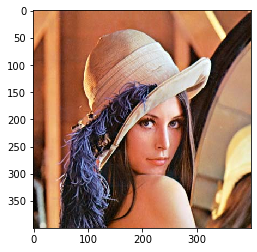

In [3]:
plt.imshow(img[:,:,::-1])

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("gray size：{}".format(gray.shape))

gray size：(400, 400)


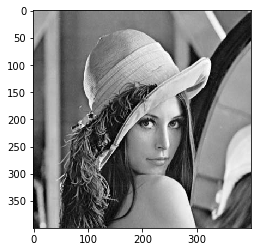

In [5]:
plt.imshow(gray,cmap='gray')

In [6]:
from pynq import DefaultIP

class SobelDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)

    bindto = ['xilinx.com:hls:sobel:1.0']

    def sobel3x3(self, imgi, imgo, rows, cols):      
        
        self.write(0x10, rows)
        self.write(0x18, cols)
        self.register_map.CTRL.AP_START = 1
        
        dma.sendchannel.transfer(imgi)
        dma.recvchannel.transfer(imgo)
        dma.sendchannel.wait() # wait for send channel
        dma.recvchannel.wait() # wait for recv channel
        
        res = imgo.reshape(rows, cols)
        return res

In [7]:
import pynq
from pynq import Overlay, allocate
#overlay = Overlay("./sobel_acc.bit")
overlay = Overlay("./sobel.bit")
dma = overlay.axi_dma_0
sobel = overlay.sobel_0

# allocate memory
rows, cols= gray.shape
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

# input
gray_new = np.uint8(gray)
np.copyto(input_buffer, gray_new.flatten())

In [9]:
import pynq
import time
rails = pynq.get_rails()
if 'VSYS' in rails.keys():
    print("Recording Ultra96 v1 power...")
    rail_name = 'VSYS'
elif 'INT' in rails.keys():
    print("Recording Ultra96 v2 power...")
    rail_name = 'INT'
else:
    raise RuntimeError("Cannot determine Ultra96 board version.")
recorder = pynq.DataRecorder(rails[rail_name].power)
recorder.reset()
time.sleep(2)
with recorder.record(0.01):
    recorder.mark()
    start_time = time.time()
    for _ in range(10000):
        res = sobel.sobel3x3(input_buffer, output_buffer, rows, cols)
    end_time = time.time()
    recorder.mark()
power_data = recorder.frame
working_power = np.mean(power_data)

print("Predict Power consumption: %.2f J" % (working_power[1] * (end_time - start_time)))


Recording Ultra96 v2 power...
Predict Power consumption: 3.63 J


In [ ]:
plt.imshow(res,cmap='gray')